# 自動微分のPython実装：autograd

自動微分を行うpythonモジュールにautogradがある．
これを使って自動微分の計算を行う．

In [1]:
# autogradのインストール

!pip install autograd

Processing /Users/tamaki/Library/Caches/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04/autograd-1.3-py3-none-any.whl


In [2]:
# numpyをｎnpとしてインポート（普通はnpだが，ここでは別名にする）
import numpy as npnp

# autograd内にnumpy互換のモジュールが用意されている．これをnpとしてインポート
import autograd.numpy as np

# from autograd import grad # こちらは1変数関数のみ（引数にarrayを受け取れない）
from autograd import elementwise_grad as grad # 引数にarrayを受け取る関数用
from autograd import jacobian


import matplotlib.pyplot as plt
%matplotlib inline

## シグモイド

まずは普通のnumpyでsigmoid関数を実装し，プロットしてみる

In [3]:
# numpyでシグモイド関数を実装
def sig(x):
    return 1 / (1 + npnp.exp(-x))

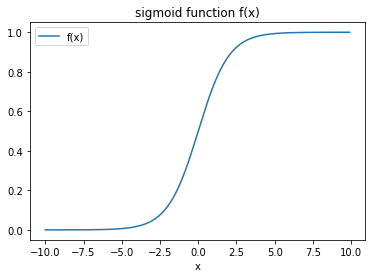

In [4]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, sig(x), label="f(x)")
plt.title("sigmoid function f(x)")
plt.xlabel("x")
plt.legend()
plt.show()

次にautograd用のnumpyでsigmoid関数を実装する．

In [5]:
# numpyでシグモイド関数を実装
def sig(x):
    return 1 / (1 + np.exp(-x))

この関数を微分するには`grad`を用いる．返り値は関数になる．

In [6]:
grad_sig = grad(sig)

In [7]:
grad_sig # autogradオブジェクトになっている

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

In [8]:
grad_sig(1.0) # 値が計算できる

0.19661193324148188

導関数は普通の関数のように使える．元の関数と同様にプロットしてみる．

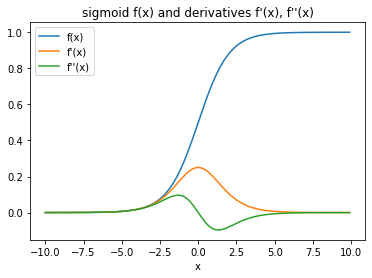

In [9]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, sig(x), label="f(x)")
plt.plot(x, grad_sig(x), label="f'(x)")
plt.plot(x, grad(grad_sig)(x), label="f''(x)") # 直接gradで関数オブジェクトを作成してもよい
plt.title("sigmoid f(x) and derivatives f'(x), f''(x)")
plt.xlabel("x")
plt.legend()
plt.show()

## 条件分岐を含む1変数関数

関数がif文を含んでもよいし，関数が不連続でもよい．
（実装上の注意：引数にarrayが取れない）

In [10]:
def f(x):
    if x >= 0: # xはスカラーのみ．arrayは不可
        return x
    else:
        return x * np.exp(x) - 1

In [11]:
grad_f = grad(f)

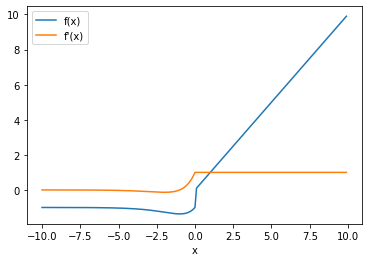

In [12]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, [f(xi) for xi in x], label="f(x)")
plt.plot(x, [grad_f(xi) for xi in x], label="f'(x)")
plt.xlabel("x")
plt.legend()
plt.show()

## 線形関数 + シグモイド

線形関数$\boldsymbol{w}^T \boldsymbol{x} + b$のあとにシグモイド関数を適用する．
つまり$\mathrm{sig}(\boldsymbol{w}^T \boldsymbol{x} + b)$を考える．


`x`は10次元ベクトルとする．`w`と`b`はランダムに初期化する．

In [13]:
N = 10
w = np.random.randn(N)
b = np.random.randn(1)

In [14]:
w, b

(array([-1.32328332, -0.46783791, -0.38186085,  0.96982505,  0.39770821,
         0.64286174, -1.58624597, -0.4588627 , -0.09384723,  1.66694224]),
 array([-0.58425362]))

線形関数を実装．シグモイド関数は先程の関数を再利用．
これが最小のネットワークなので，`small_net`と名付ける．連鎖率は自動的に適用される．

In [15]:
def linear(x):
    h = w.dot(x) + b
    return h

In [16]:
def small_net(x):
    return sig(linear(x))

微分（勾配ベクトル）を計算．

In [17]:
grad_small_net = grad(small_net)

呼び出せることを確認する．

In [18]:
small_net(np.random.randn(N))

array([0.96771679])

In [19]:
grad_small_net(np.random.randn(N))

array([-0.29006466, -0.10255041, -0.08370417,  0.21258635,  0.08717793,
        0.14091576, -0.34770626, -0.10058303, -0.02057138,  0.36539494])

# ヤコビ行列の計算

ベクトル値関数のヤコビ行列（微分）の計算には`jacobian`を用いる．

## アフィン関数の例

入力`x`のアフィン関数
$W \boldsymbol{x} + \boldsymbol{b}$
を考える．
入力`x`は$M$次元，出力は$N$次元の関数である．

In [20]:
N = 2
M = 3
W = np.random.randn(N, M)
b = np.random.randn(N)

In [21]:
W, b

(array([[ 1.77678434,  0.26131419,  0.14902853],
        [-2.43937234,  0.07548175, -0.03492732]]),
 array([0.56160253, 0.16453598]))

アフィン関数を`tiny_net`とする．

In [22]:
def tiny_net(x):
    h = np.dot(W, x) + b # 注意：autograd.numpyではW.dot(x)は使えない．np.dot(W, x)を使う．
    return h

ヤコビ行列を計算する（つまりヤコビ行列関数を作成する）．

In [23]:
Jacobian_tiny_net = jacobian(tiny_net)

In [24]:
x = np.random.randn(M) # ランダムな入力

In [25]:
tiny_net(x) # xを入力

array([ 3.10873748, -2.80833723])

In [26]:
Jacobian_tiny_net(x) # 入力がxの時のヤコビ行列

array([[ 1.77678434,  0.26131419,  0.14902853],
       [-2.43937234,  0.07548175, -0.03492732]])

この場合のヤコビ行列は$W$であるので，この出力が`W`と一致している．

## 非線形関数の例

$\boldsymbol{f}(\boldsymbol{p}) =
                \begin{pmatrix}
                a \sin(bx+c) \\ a\cos(bx+c)
                \end{pmatrix},
			\boldsymbol{p}=
                \begin{pmatrix}
                 a \\ b \\ c
                \end{pmatrix}            
$
の
ヤコビ行列
$\dfrac{\partial\boldsymbol{f}}{\partial \boldsymbol{p}}$
を求める．

In [27]:
def f(p):
    a, b, c = p # 3D parameter vector
    f1 = a * np.sin(b * x + c)
    f2 = a * np.cos(b * x + c)
    return np.array([f1, f2])

In [28]:
df_dp = jacobian(f)

In [29]:
x = 10.0 # use float. using int results in errors...
p = np.array([10.0, 2.0, 4.0]) # use float !

In [30]:
f(p)

array([-9.05578362,  4.24179007])

In [31]:
df_dp(p)

array([[-0.90557836, 42.41790073,  4.24179007],
       [ 0.42417901, 90.5578362 ,  9.05578362]])

# Task

## 勾配ベクトル

以下の関数の勾配ベクトルをautogradで求めよ．
また手作業で勾配ベクトル関数を求めて通常の関数として実装せよ．
この2つの勾配ベクトル関数にランダムな入力を多数回入力して，出力が毎回一致することを確認せよ．

- $f(\boldsymbol{w}) = \boldsymbol{w}^T A \boldsymbol{w}$
- $f(X) = \boldsymbol{a}^T X \boldsymbol{b}$

$a, b, A$は適当でよい．

## ヤコビ行列

以下の関数のヤコビ行列をautogradで求めよ．
また手作業でヤコビ行列関数を求めて通常の関数として実装せよ．
この2つのヤコビ行列関数にランダムな入力を多数回入力して，出力が毎回一致することを確認せよ．

$\boldsymbol{f}(\boldsymbol{a}) = R(a) R(b) \boldsymbol{x}$

ここで
$\boldsymbol{x} = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix},
\boldsymbol{a} = \begin{pmatrix} a \\ b \end{pmatrix},
R(\theta) = \begin{pmatrix}
\sin\theta & \cos\theta \\
-\cos\theta & \sin\theta
\end{pmatrix}
$

$\boldsymbol{x}$は適当でよい